In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
base_f_loc = '/storage/silver/stfc_cg/hf832176/data/THEMIS/'

In [61]:
spacecraft = 'tha'

f_loc = base_f_loc+spacecraft+'/'

# <center> Read in Data </center>

In [62]:
!ls {f_loc}*.pkl

/storage/silver/stfc_cg/hf832176/data/THEMIS/tha/tha_fgm.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha/tha_sst_energy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha/tha_sstenergy_levels.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha/tha_sst.pkl
/storage/silver/stfc_cg/hf832176/data/THEMIS/tha/tha_state.pkl


In [63]:
fgm = pd.read_pickle(f_loc+spacecraft+'_fgm.pkl')
sst = pd.read_pickle(f_loc+spacecraft+'_sst.pkl')
state = pd.read_pickle(f_loc+spacecraft+'_state.pkl')
# e_levels = pd.read_pickle(f_loc+spacecraft+'_sst_energy_levels.pkl')

# <center> Resample and Concatenate Data </center>

In [64]:
sst = sst.resample('3T',loffset=dt.timedelta(minutes=1)).mean()
state = state.resample('3T',loffset=dt.timedelta(minutes=1)).mean()
fgm = fgm.resample('3T',loffset=dt.timedelta(minutes=1)).mean()
# sst.head()

In [65]:
print(sst.shape,state.shape,fgm.shape)

(119194, 16) (124800, 10) (123675, 3)


In [66]:
tha = pd.concat([sst,fgm,state],axis=1)
tha.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124801 entries, 2007-09-15 00:01:00 to 2008-06-01 00:01:00
Freq: 3T
Data columns (total 29 columns):
E_1           99886 non-null float64
E_10          99886 non-null float64
E_11          99886 non-null float64
E_12          0 non-null float64
E_13          0 non-null float64
E_14          0 non-null float64
E_15          0 non-null float64
E_16          0 non-null float64
E_2           99886 non-null float64
E_3           99886 non-null float64
E_4           99886 non-null float64
E_5           99886 non-null float64
E_6           99886 non-null float64
E_7           99886 non-null float64
E_8           99886 non-null float64
E_9           99886 non-null float64
Bx_gsm        73284 non-null float32
By_gsm        73284 non-null float32
Bz_gsm        73284 non-null float32
pos_x_gsm     116640 non-null float32
pos_y_gsm     116640 non-null float32
pos_z_gsm     116640 non-null float32
spin_ra       116640 non-null float32
spin_dec   

# <center> Additional Data </center>

## GSM Radial Distance

R$_E$ = 6378.1 km

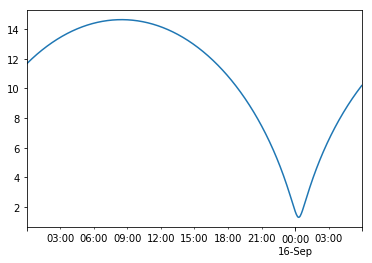

In [67]:
RE = 6378.1

tha['r'] = [np.linalg.norm(i)/RE for i in tha[['pos_x_gsm','pos_y_gsm','pos_z_gsm']].values]

tha['r'].iloc[:600].plot()

## GSM -> MLT

If you thought THEMIS GSM$^{TM}$ was the same as usual GSM, guess again!

X is positive towards the Sun.
Z is positive towards Magnetic North.
Y is positive towards... dusk.

$\theta_a = Tan^{-1}(Y/X)$

$\theta_b = Tan^{-1}(X/Y)$

(X < 0, Y < 0): $MLT = 6 \left(\frac{\theta_a}{\pi/2}\right)$

(X > 0, Y < 0): $MLT = 6 \left(\frac{\theta_b}{\pi/2}\right) + 6$

(X > 0, Y > 0): $MLT = 6 \left(\frac{\theta_a}{\pi/2}\right) + 12$

(X < 0, Y > 0): $MLT = 6 \left(\frac{\theta_b}{\pi/2}\right) + 18$

In [68]:
mlt_arr = []
for x,y in zip(tha['pos_x_gsm'],tha['pos_y_gsm']):
# for x,y in zip([-3,3,-3,3],[2,2,-2,-2]):
    if y < 0:
        theta_a = np.arctan(np.abs(y)/np.abs(x))
        theta_b = np.arctan(np.abs(x)/np.abs(y))
        if x <= 0:
            mlt = 6*(theta_a/(np.pi/2))
            mlt_arr.append(mlt)
        elif x > 0:
            mlt = 6*(theta_b/(np.pi/2)) + 6
            mlt_arr.append(mlt)
            
    elif y > 0:
        theta_a = np.arctan(np.abs(y)/np.abs(x))
        theta_b = np.arctan(np.abs(x)/np.abs(y))
        if x > 0:
            mlt = 6*(theta_a/(np.pi/2)) + 12
            mlt_arr.append(mlt)
        elif x <= 0:
            mlt = 6*(theta_b/(np.pi/2)) + 18
            mlt_arr.append(mlt)
    else:
        mlt_arr.append(np.nan)
            
tha['mlt'] = mlt_arr

In [69]:
tha.to_pickle(base_f_loc+spacecraft+'.pkl')

# <center> Plotting Data </center>

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

/home/users/hf832176/.conda/envs/tb_env5/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/hf832176/.conda/envs/tb_env5/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


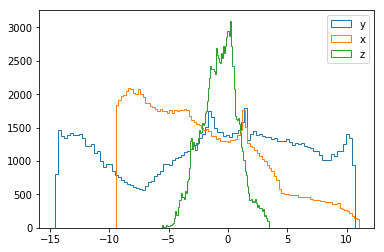

In [13]:
plt.hist(tha['pos_y_gsm']/6378.1,bins=100,histtype='step',label='y')
plt.hist(tha['pos_x_gsm']/6378.1,bins=100,histtype='step',label='x')
plt.hist(tha['pos_z_gsm']/6378.1,bins=100,histtype='step',label='z')
plt.legend()
plt.show()

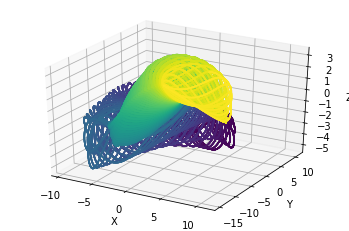

In [14]:
fig = plt.figure()
ax = plt.axes(projection='3d')

viridis = cm.get_cmap('viridis', len(tha))
for i in range(len(tha)):
    colour = viridis(i/len(tha))
    ax.plot(tha['pos_x_gsm'][i:i+2]/6378.1,
            tha['pos_y_gsm'][i:i+2]/6378.1,
            tha['pos_z_gsm'][i:i+2]/6378.1,
            c=colour)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [15]:
equa_r = tha[(np.abs(tha['pos_z_gsm']/6378.1)<1) &
             (tha['r'] >= 7)]
dawn = equa_r[(3 <= equa_r['mlt']) &
                  (equa_r['mlt'] <= 9)]
dusk = equa_r[(15 <= equa_r['mlt']) &
                  (equa_r['mlt'] <= 21)]
print(len(tha),len(equa_r),len(dawn),len(dusk))

124801 27886 10595 9694
